In [2]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters
import time
import datetime
import os.path
import io

import os
os.environ["PATH"] += os.pathsep + "."

%matplotlib inline

In [5]:
folder = 'C:\Projects\Bike Hire\Weekly 2022'
df = []
for file in os.listdir(folder):
    if file.endswith('.csv'):
        print('Loading file {0}...'.format(file))
        df.append(pd.read_csv(os.path.join(folder,file)))
journey = pd.concat(df)

Loading file week1.csv...
Loading file week10.csv...
Loading file week11.csv...
Loading file week12.csv...
Loading file week13.csv...
Loading file week14.csv...
Loading file week15.csv...
Loading file week16.csv...
Loading file week17.csv...
Loading file week18.csv...
Loading file week19.csv...
Loading file week2.csv...
Loading file week20.csv...
Loading file week21.csv...
Loading file week22.csv...
Loading file week23.csv...
Loading file week24.csv...
Loading file week25.csv...
Loading file week26.csv...
Loading file week27.csv...
Loading file week3.csv...
Loading file week4.csv...
Loading file week5.csv...
Loading file week6.csv...
Loading file week7.csv...
Loading file week8.csv...
Loading file week9.csv...


In [6]:
journey["Start Time"] = pd.to_datetime(journey["Start Date"], format= '%d-%m-%Y %H:%M')
journey["End Time"] = pd.to_datetime(journey["End Date"], format= '%d-%m-%Y %H:%M')
journey["Hour"] = journey["Start Time"].map(lambda x: x.hour)
journey.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,EndStation Latitude,EndStation Longitude,StartStation Latitude,StartStation Longitude,Start Time,End Time,Hour
0,115967515,1260,15338,01-01-2022 23:13,310,"Black Prince Road, Vauxhall",01-01-2022 22:52,529,"Manresa Road, Chelsea",51.4909,-0.116912,51.4869,-0.170983,2022-01-01 22:52:00,2022-01-01 23:13:00,22
1,116017034,720,19861,04-01-2022 19:08,11,"Brunswick Square, Bloomsbury",04-01-2022 18:56,804,"Good's Way, King's Cross",51.5240,-0.122502,51.5347,-0.125079,2022-01-04 18:56:00,2022-01-04 19:08:00,18
2,116016563,480,19861,04-01-2022 18:46,804,"Good's Way, King's Cross",04-01-2022 18:38,57,"Guilford Street , Bloomsbury",51.5347,-0.125079,51.5233,-0.120203,2022-01-04 18:38:00,2022-01-04 18:46:00,18
3,116014412,1260,17235,04-01-2022 17:45,14,"Belgrove Street , King's Cross",04-01-2022 17:24,297,"Geraldine Street, Elephant & Castle",51.5299,-0.123617,51.4961,-0.106001,2022-01-04 17:24:00,2022-01-04 17:45:00,17
4,116013350,480,13790,04-01-2022 16:50,252,"Jubilee Gardens, South Bank",04-01-2022 16:42,310,"Black Prince Road, Vauxhall",51.5046,-0.116542,51.4909,-0.116912,2022-01-04 16:42:00,2022-01-04 16:50:00,16


In [7]:
def get_kernel(kernel_size, blur=1/20, halo=.001):
    """
    Create an (n*2+1)x(n*2+1) numpy array.
    Output can be used as the kernel for convolution.
    """
    
    # generate x and y grids
    x, y = np.mgrid[0:kernel_size*2+1, 0:kernel_size*2+1]
    
    center = kernel_size + 1  # center pixel
    r = np.sqrt((x - center)**2 + (y - center)**2)  # distance from center
    
    # now compute the kernel. This function is a bit arbitrary. 
    # adjust this to get the effect you want.
    kernel = np.exp(-r/kernel_size/blur) + (1 - r/r[center,0]).clip(0)*halo
    return kernel

In [8]:
def add_lines(image_array, xys, width=1, weights=None):
    """
    Add a set of lines (xys) to an existing image_array
    width: width of lines
    weights: [], optional list of multipliers for lines. 
    """
    
    for i, xy in enumerate(xys):  # loop over lines
        # create a new gray scale image
        image = Image.new("L",(image_array.shape[1], image_array.shape[0]))
        
        # draw the line
        ImageDraw.Draw(image).line(xy, 200, width=width)
        
        #convert to array
        new_image_array = np.asarray(image, dtype=np.uint8).astype(float)
        
        # apply weights if provided
        if weights is not None:
            new_image_array *= weights[i]
            
        # add to existing array
        image_array += new_image_array

    # convolve image
    new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4)) 
    return new_image_array

In [9]:
def to_image(array, hue=.62):
    """converts an array of floats to an array of RGB values using a colormap"""
    
    # apply saturation function
    image_data = np.log(array + 1)
    
    # create colormap, change these values to adjust to look of your plot
    saturation_values = [[0, 0], [.75, .68], [.78, .87], [0, 1]]
    colors = [hsv_to_rgb([hue, x, y]) for x, y in saturation_values]
    cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
    
    # apply colormap
    out = cmap(image_data/image_data.max())
    
    # convert to 8-bit unsigned integer
    out = (out*255).astype(np.uint8)
    return out

In [14]:
def get_min_max(journey):
    min_lat = journey["StartStation Latitude"].min()
    max_lat = journey["StartStation Latitude"].max()
    max_lon = journey["StartStation Longitude"].max()
    min_lon = journey["StartStation Longitude"].min()
    return min_lat, max_lat, min_lon, max_lon

In [16]:
def latlon_to_pixel(lat, lon, image_shape, bounds):
    min_lat, max_lat, min_lon, max_lon = bounds

    # longitude to pixel conversion (fit data to image)
    delta_x = image_shape[1]/(max_lon-min_lon)
    
    # latitude to pixel conversion (maintain aspect ratio)
    delta_y = delta_x/np.cos(lat/360*np.pi*2)
    pixel_y = (max_lat-lat)*delta_y
    pixel_x = (lon-min_lon)*delta_x
    return (pixel_y,pixel_x)

In [26]:
def row_to_pixel(row,image_shape,bounds):
    # convert a row (1 trip) to pixel coordinates of start and end point
    
    start_y, start_x = latlon_to_pixel(row["StartStation Latitude"], 
                                       row["StartStation Longitude"], image_shape, bounds)
    end_y, end_x = latlon_to_pixel(row["EndStation Latitude"], 
                                   row["EndStation Longitude"], image_shape, bounds)
    xy = (start_x, start_y, end_x, end_y)
    return xy

C:\Users\diksh\AppData\Local\Temp\ipykernel_3908\3207941489.py:26: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4))


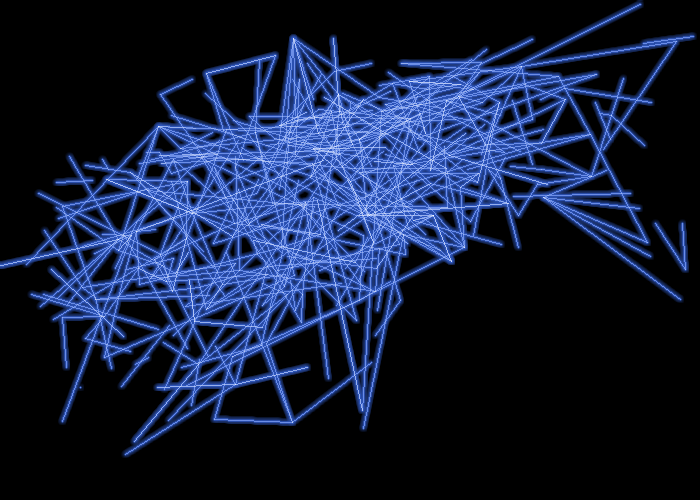

In [27]:
paths = journey[journey.Hour==9]
paths = paths.iloc[:500:]

# generate empty pixel array, choose your resolution
image_data = np.zeros((500,700))
bounds = get_min_max(journey)

# generate pixel coordinates of starting points and end points
xys = [row_to_pixel(row, image_data.shape, bounds) for i, row in paths.iterrows()]

# draw the lines
image_data = add_lines(image_data, xys, weights=None, width = 1)
Image.fromarray(to_image(image_data*10)[:,:,:3],mode="RGB")

In [29]:
def get_path_progress(trips, image_time):
    """ return a series of numbers between 0 and 1 
    indicating the progress of each trip at the given time"""
    
    trip_duration = trips["End Time"] - trips["Start Time"]
    path_progress = (image_time - trips["Start Time"]).dt.total_seconds() / trip_duration.dt.total_seconds()
    return path_progress

def get_current_position(trips, progress):
    """ Return Latitude and Longitude for the 'current position' of each trip.
    Paths are assumed to be straight lines between start and end. 
    """
    
    current_latitude = trips["StartStation Latitude"]*(1- progress) + \
                       trips["EndStation Latitude"]* progress
    current_longitude = trips["StartStation Longitude"]*(1- progress) + \
                       trips["EndStation Longitude"]* progress
    return current_latitude, current_longitude

In [30]:
def get_active_trips(image_time, journey, image_shape, line_len = .1):
    """ Return pixel coordinates only for trips that have started and 
    not yet completed for the given time.
    """
    
    bounds = get_min_max(journey)
    
    active_trips = journey[(journey["Start Time"]<=image_time)]
    active_trips = active_trips[(active_trips["End Time"]>=image_time)].copy()
    
    progress = get_path_progress(active_trips, image_time)
    
    current_latitude, current_longitude = get_current_position(active_trips, progress)
    start_latitude, start_longitude = get_current_position(active_trips, np.clip(progress-line_len, 0, 1))
    
    start_y, start_x = latlon_to_pixel(start_latitude, 
                                          start_longitude, 
                                          image_shape,
                                          bounds)
    
    end_y, end_x = latlon_to_pixel(current_latitude, 
                                      current_longitude, 
                                      image_shape,
                                      bounds)
    xys = list(zip(start_x, start_y, end_x, end_y))
    weights = np.clip((1 - progress.values)*100, 0, 1)
    
    return xys, weights

In [31]:
def row_to_pixel(row, image_shape, bounds):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = latlon_to_pixel(row["StartStation Latitude"], 
                                          row["StartStation Longitude"], 
                                          image_shape,
                                          bounds)
    end_y, end_x = latlon_to_pixel(row["EndStation Latitude"], 
                                      row["EndStation Longitude"], 
                                      image_shape,
                                      bounds)
    xy = (start_x, start_y, end_x, end_y)
    return xy

In [32]:
def add_alpha(image_data):
    """
    Uses the Value in HSV as an alpha channel. 
    This creates an image that blends nicely with a black background.
    """
    
    # get hsv image
    hsv = rgb_to_hsv(image_data[:,:,:3].astype(float)/255)
    
    # create new image and set alpha channel
    new_image_data = np.zeros(image_data.shape)
    new_image_data[:,:,3] = hsv[:,:,2]
    
    # set value of hsv image to either 0 or 1.
    hsv[:,:,2] = np.where(hsv[:,:,2]>0, 1, 0)
    
    # combine alpha and new rgb
    new_image_data[:,:,:3] = hsv_to_rgb(hsv)
    return new_image_data

In [33]:
def create_image_map(image_data, bounds):
    min_lat, max_lat, min_lon, max_lon = bounds
    folium_map = folium.Map(location=[51.47, -0.140],
                            zoom_start=12,
                            tiles="CartoDB dark_matter",
                            width='100%')

    # create the overlay
    map_overlay = add_alpha(to_image(image_data))

    # compute extent of image in lat/lon
    aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
    delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)

    # add the image to the map
    img = folium.raster_layers.ImageOverlay(map_overlay,
                               bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                               opacity = 1,
                               name = "Paths")

    img.add_to(folium_map)
    folium.LayerControl().add_to(folium_map)

    # return the map
    return folium_map

In [34]:
def get_image_map(frame_time, journey):
    """Create the folium map for the given time"""
    
    image_data = np.zeros((600*2,600*2))
    bounds = get_min_max(journey)
    
    # plot the current locations
    xys, weights = get_active_trips(frame_time, journey, image_data.shape, line_len=.01)
    image_data = add_lines(image_data, xys, weights=weights*20, width = 4)
    
    #  plot the paths
    xys, weights = get_active_trips(frame_time, journey, image_data.shape, line_len=1)
    image_data = add_lines(image_data, xys, weights=weights*10, width = 2)
    
    # generate and return the folium map.
    return create_image_map(image_data, bounds)

C:\Users\diksh\AppData\Local\Temp\ipykernel_3908\3207941489.py:26: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4))



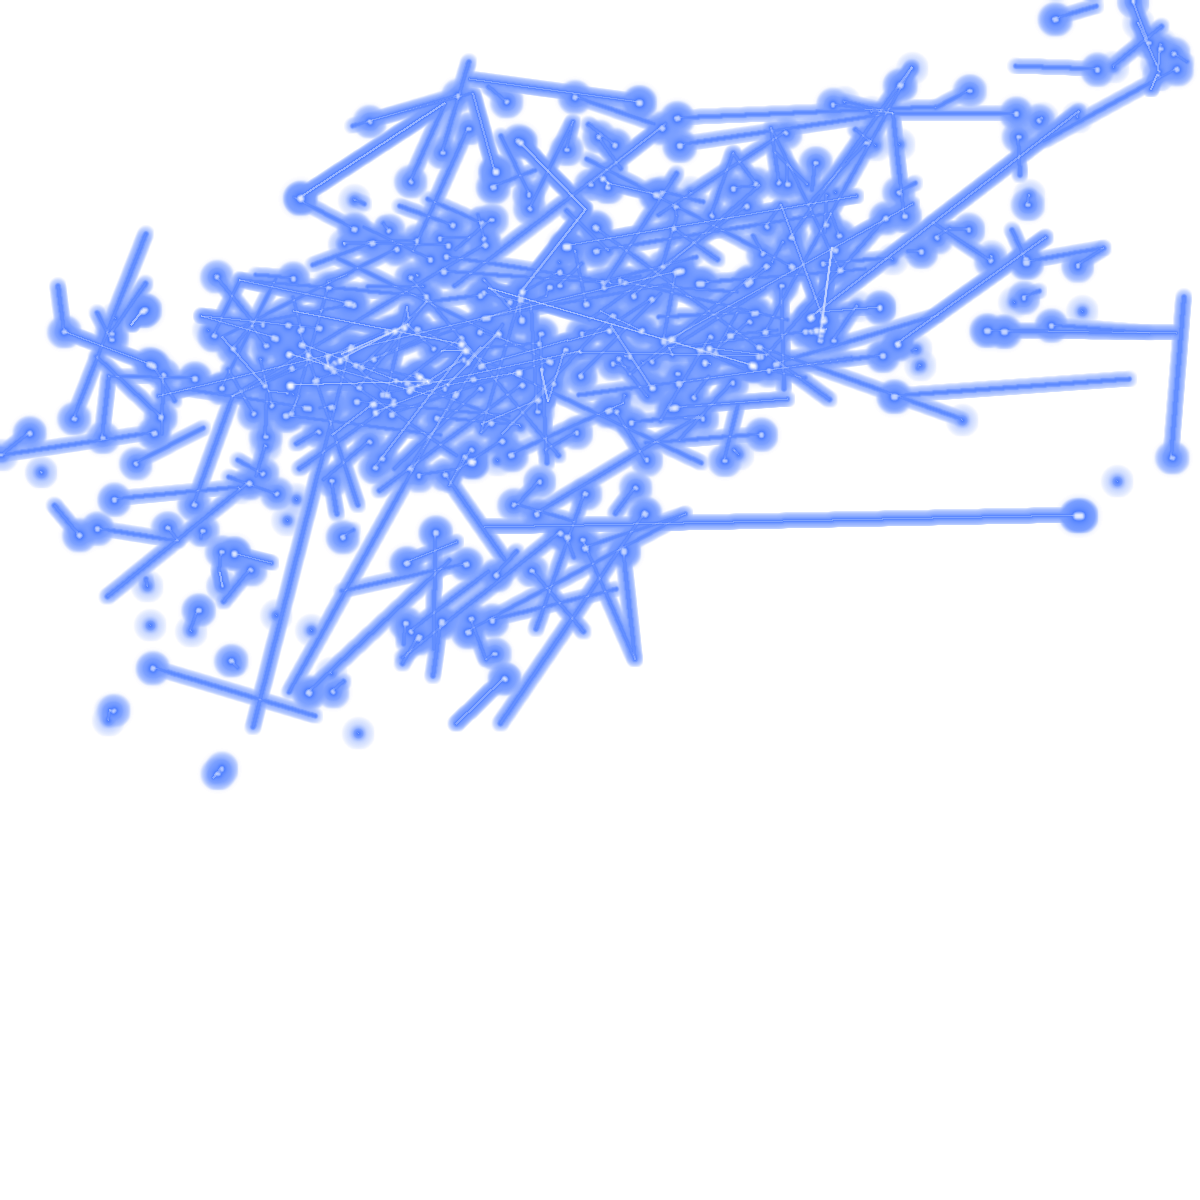

In [35]:
get_image_map(pd.to_datetime('2022-06-01 13:00:00'), journey)

In [36]:
def go_paths_frame(params):
    """Similar to go_arrivals_frame.
    Generate the image, add annotations, and save image file."""
    i, frame_time = params
    
    my_frame = get_image_map(frame_time, journey)
    png = my_frame._to_png()
    
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    font = ImageFont.truetype("arial.ttf", 30)
    
    # add date and time of day text
    draw.text((20, image.height - 50), 
              "time: {}".format(frame_time),
              fill=(255, 255, 255), 
              font=font)
    
    # draw title
    draw.text((image.width - 1300,20), 
              "Paths of Individual Bike Trips",
              fill=(255, 255, 255), 
              font=font)
    
    # write to a png file
    dir_name = "path_frames"
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    image.save(os.path.join(dir_name, "frame_{:0>5}.png".format(i)), "PNG")
    return image

C:\Users\diksh\AppData\Local\Temp\ipykernel_3908\3207941489.py:26: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4))


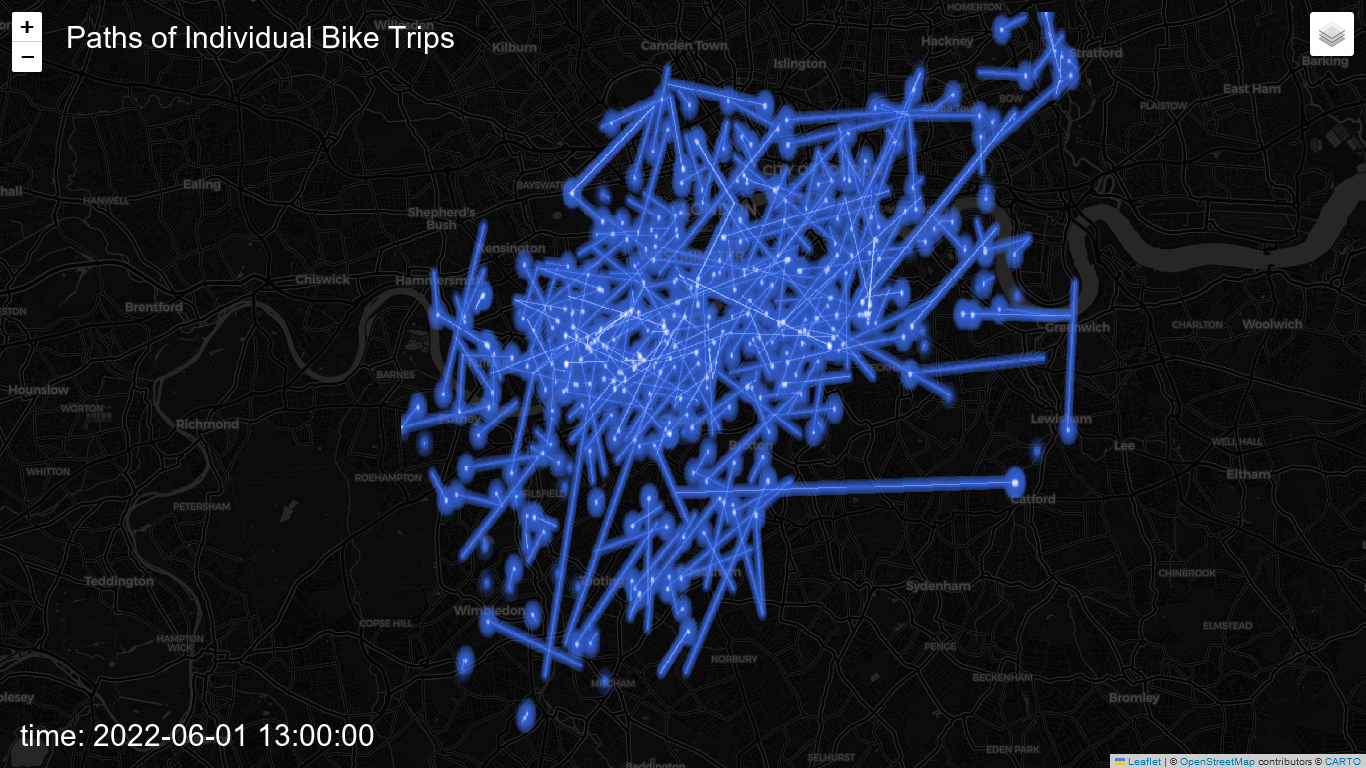

In [39]:
# an example output.
go_paths_frame((1, pd.to_datetime('2022-06-01 13:00:00')))